In [1]:
import matplotlib.pyplot as plt
import numpy as np

import context
import src.switchedkalman as sk

In [2]:
np.random.seed(1234)

switching_times = [1,2]  #times when the dynamics switch
Tf = 3  #final simulation time

# time step
dt = 2**-6 #choose a power of 2

t0=0
x0=np.array([0])
w0=1 #initial mode
sigma = .01  # measurement noise

u = [np.array([1]), np.array([-1])] #system dynamics

### Simulation

The system dynamics are
$$
\dot{x}(t) = \begin{cases} 1 & w = 0 \\ -1 & w = 1 \end{cases}.
$$

For ease of simulation, we define the discrete state to be
$$
w(t) = \begin{cases} 0 & 0 \le t < 1 \\ 1  & 1\le t < 2 \\ 0 & 2 \le t \end{cases}
$$

In [3]:
def sim_system(resets= False, reset_size = None):
    t = t0
    w = w0
    x = x0
    m = x + np.random.normal(0,sigma)
    
    warray =[w]
    xarray =[x]
    tarray =[t]
    marray =[m]
    
    while t <Tf:
        x = x + dt*u[w]
        t = t + dt
        if t in switching_times:
            w = (w+1)%2
            if resets:
                if reset_size is None:
                    x = x*0
                else:
                    x = x + reset_size
            
        warray.append(w)
        tarray.append(t)
        xarray.append(x)
        marray.append(x+np.random.normal(0,sigma))
        
    t = np.asarray(tarray)
    x = np.asarray(xarray)
    w = np.asarray(warray)
    m = np.asarray(marray)
    return t,x,w,m

In [4]:
def plot_data(t,x,w,xhat,what):
    fig,ax= plt.subplots(3,1, figsize=(6,8), sharex=True)
    ax[0].plot(t,xhat-x)
    ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(xhat-x,2)))))
    ax[0].set_ylabel('$\hat{x}-x$')
    ax[1].plot(t,x, '--')
    ax[1].plot(t, xhat)
    ax[1].set_ylabel('continuous state ($x$)')
    ax[2].plot(t,what);
    ax[2].plot(t,w)
    ax[2].set_ylabel('discrete state ($w$)')
    ax[2].legend(['Estimate','True'])
    return fig,ax

## Nonsmooth Variable Projection
### Algorithm setup

In [5]:
# define system dynamics for all modes
fs = [lambda x: x + u[0]*dt, lambda x: x+u[1]*dt]
# derivative of the system dynamics
grads = [lambda x: [1.], lambda x: [1.]]
# measurement matrix
H = np.asarray([[1]])

# number of time steps
T = int(Tf/dt)+1
G = [fs for _ in range(T)]
dG =[grads for _ in range(T)]

# tunned default parameters
Qinv = np.diag([1])
Rinv = np.diag([1.])
r = .1
nu = .001
beta = 1e-10
itr = 10



In [6]:
def variable_projection(meas, Qinv=Qinv, Rinv=Rinv, nu=nu, beta=beta, r=r, itr = itr):
    # itr - number of itereations to run the alogrithm
    # remaining terms defined in sk.SwitchedKalman
    
    np.random.randn(127)
    model = sk.SwitchedKalman(m,G,dG,H,Qinv,Rinv,x0,r)

    smooth_x = np.random.randn(T,1)*.1
    smooth_w = np.random.rand(T,2)
    
    loss = []
    for k in range(itr):
        smooth_x,_ = model.updateX(smooth_x,smooth_w, iter=1)
        smooth_w,_ = model.updateW(smooth_w,smooth_x,nu,beta,iter=1)
        loss.append(model.computeObj(smooth_x,smooth_w,nu,beta))
        
    return smooth_x, smooth_w, loss

## Continuous Trajectory (no resets)

In [7]:
t,x,w,m = sim_system(resets=False)

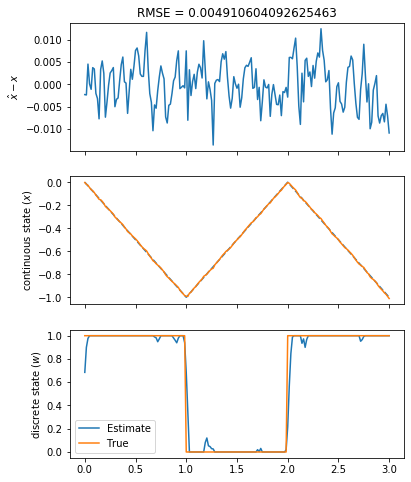

In [8]:
smooth_x, smooth_w, loss = variable_projection(m)
plot_data(t,x,w,smooth_x,smooth_w[:,1]);

## Discontinuous Trajectory (with resets)

In [9]:
t,x,w,m = sim_system(resets=True, reset_size=-5)

In [10]:
smooth_x, smooth_w, loss = variable_projection(m)

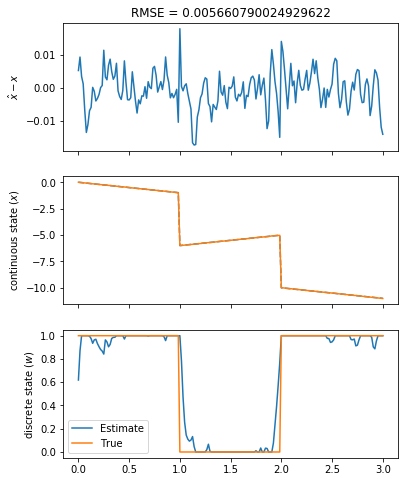

In [11]:
plot_data(t,x,w,smooth_x,smooth_w[:,1]);